# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import cv2
import matplotlib.pyplot as plt

# TODO: Fill this in based on where you saved the training and testing data
training_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/train.p"
testing_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# Number of training examples
n_train = len(y_train)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train[1].shape

# How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

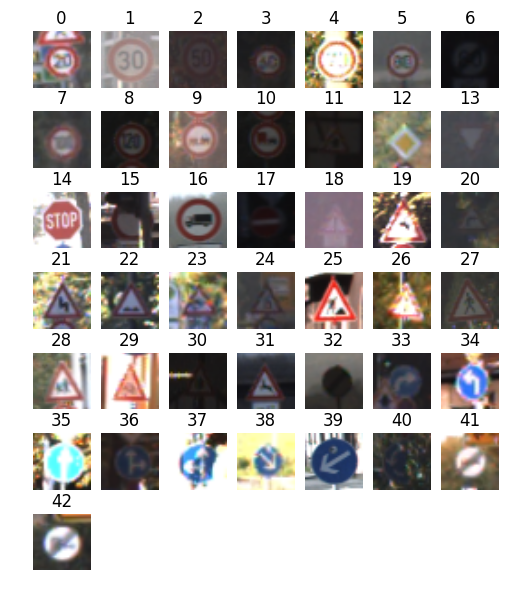

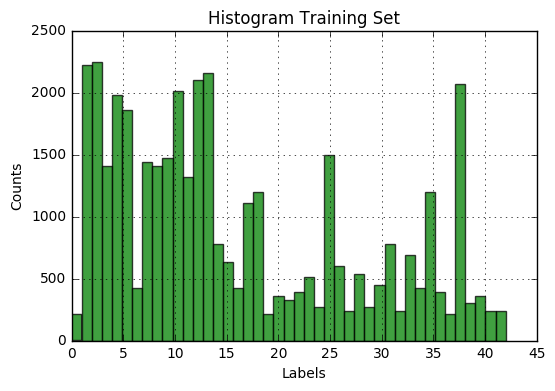

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import numpy as np

# Visualizations will be shown in the notebook.
%matplotlib inline

label, indices = np.unique(y_train, return_index=True)
unique, counts = np.unique(y_train, return_counts=True)

image = X_train[indices].squeeze()

fig = plt.figure()
for i in range(image.shape[0]):
    a=fig.add_subplot(7,7,i+1)
    imgplot = plt.imshow(image[i])
    a.set_title(label[i])
    plt.axis('off')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5,
                wspace=None, hspace=None)

fig = plt.figure()
n, bins, patches = plt.hist(y_train, bins=unique.shape[0], facecolor='green', alpha=0.75)

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title(r'Histogram Training Set')
plt.grid(True)

plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
# Global normalization
import cv2

def toRank3(gray_image):
    result = np.zeros((gray_image.shape[0], gray_image.shape[1], 1), dtype=gray_image.dtype)
    result[:, :, 0] = gray_image
    return result

def imagePreprocessing(image):
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # convert data type to float and scale from [0,255] to [0.0,1.0]
    y_channel = yuv[:, :, 0]
    y_channel = np.float32(y_channel)
    y_channel = y_channel * 1.0/255.0
    
    # Center image to zero mean
    local_mean = cv2.GaussianBlur(y_channel, (11, 11), 1, 1)
    zero_mean = y_channel - local_mean

    # scale to normalize the image to one standart deviation
    local_variance = cv2.GaussianBlur(np.multiply(zero_mean, zero_mean), (11, 11), 1, 1)
    variance_mean = np.mean(local_variance)
    local_std = np.sqrt(np.maximum(local_variance, variance_mean))
    local_norm = np.divide(zero_mean, local_std)
    
    # Global normalization
    global_norm = cv2.normalize(local_norm, 0.0, 1.0)
    
    # Put the result in a container with the shape [32, 32, 1],
    # This is mainly to make it easier to switch the return image between colored or non-colored
    output = toRank3(global_norm)
    return output



In [5]:
X_train_original = X_train
X_test_original = X_test

# start preprocessing
print("Preprocessing training data...")
X_train_processed = []
for img in X_train:
    X_train_processed.append(imagePreprocessing(img))
    
X_train_processed = np.concatenate([img[np.newaxis] for img in X_train_processed])
X_train = X_train_processed;
print("done")
print(X_train.shape)


print("Preprocessing testing data...")
X_test_processed = []
for img in X_test:
    X_test_processed.append(imagePreprocessing(img))
    
X_test_processed = np.concatenate([img[np.newaxis] for img in X_test_processed])
X_test = X_test_processed;
print("done")
print(X_test.shape)


Preprocessing training data...
done
(39209, 32, 32, 1)
Preprocessing testing data...
done
(12630, 32, 32, 1)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I first converted all the training and testing image into YUV. Then I performed global and local normalization only on Y channel.

Global Normalization scale image Y channel into [0.0, 1.0]. This provides numerical stability and faster convergence.

Local Normalization emphasizes the edges (got the idea from LeCun's paper). This uniformizes the local mean and variance of the image to correct non-uniform illumination or shading artifacts (http://bigwww.epfl.ch/sage/soft/localnormalization/)

I did several test with RGB image, YUV image and only Y channel of the YUV image. I got the best result with only passing Y channel to the neural network, which is consistent with LeCun's paper.

I used OpenCV for all the image operations. Here's how I did the preprocessing:
1. Convert the image to YUV channel. Take the Y channel and convert the data type to float and scale the pixel value to [0,1]
2. Calculate local means of the y_channel using Gaussian blur of window size 11 and sigma 1
3. Substract local means from the y_channel to get zero mean.
4. Calculate the local standard deviations of the y_channel. Using Gaussian blur of window size 11 and sigma 1. 
5. Divide zero-mean output from step 2 by max(local_std, mean(local_stds)) (the maximum of the local standard deviations and the mean of them). The max function is preformed to prevent zero divisor.



In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import cv2

# Rotate images
def randomRotation(lower, upper, image):
    angle = random.uniform(lower, upper)
    #print ("Rotate Image for: ", angle)
    rows = image.shape[0]
    cols = image.shape[1]
    T = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    rotated = cv2.warpAffine(image, T, (cols, rows))    
    output = toRank3(rotated)
    return output

# Translate images
def randomShift(lower, upper, image):
    delta = random.uniform(lower, upper)
    #print ("Shift Image for: ", delta)
    rows = image.shape[0]
    cols = image.shape[1]
    T = np.float32([[1, 0, delta],[0, 1, delta]])
    shifted = cv2.warpAffine(image, T, (cols, rows))    
    output = toRank3(shifted)
    return output


# Zoom images
def randomZoom(lower, upper, image):
    scale = random.uniform(lower, upper)
    #print ("Scale Image for: ", scale)
    zoomed = cv2.resize(image, None,fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)
    zoomed = toRank3(zoomed)
    
    # start idx for crop or padding
    zoomed_hw = zoomed.shape[:2]
    input_hw = image.shape[:2]    
    start_idx = abs(np.divide(np.add(zoomed_hw, np.multiply(input_hw, -1)), 2))
    start_idx = start_idx.astype(int)

    # crop or pad to get output images
    output = np.zeros(image.shape, dtype=image.dtype)
    if scale >= 1:
        end_idx = np.add(start_idx, input_hw) 
        output = zoomed[start_idx[0]:end_idx[0], start_idx[1]:end_idx[1], :]
    else:
        end_idx = np.add(start_idx, zoomed_hw)
        output[start_idx[0]:end_idx[0], start_idx[1]:end_idx[1], :] = zoomed       
    return output

# Separate validation data from Training data
def trainValidationSplit(X_train, y_train, percentage):
    X_validation = np.array([], dtype=X_train.dtype).reshape(0, X_train.shape[1], X_train.shape[2], 1)
    y_validation = np.array([], dtype=X_train.dtype)
    X_train_new = X_train;
    y_train_new = y_train;
    # Randomly choose images equally from each categories with specified percentage
    for sign_index in range(0, 43):
        index_pool = np.asarray(np.where(y_train==sign_index))
        index = np.random.choice(index_pool[0], int(float(index_pool[0].shape[0])*percentage))
        X_validation = np.concatenate((X_validation, X_train[index]), axis=0)
        y_validation = np.concatenate((y_validation, y_train[index]), axis=0)
        X_train_new = np.delete(X_train_new, index, 0)
        y_train_new = np.delete(y_train_new, index, 0)
    
    X_train = X_train_new
    y_train = y_train_new
    
    print("X_train:",X_train.shape)
    print("y_train:",y_train.shape)
    print("x_validation:",X_validation.shape)
    print("y_validation:",y_validation.shape)
   
    return X_train, X_validation, y_train, y_validation


In [7]:
additional_img = []
additional_label = []
print ("Rotating, Shifting, Zooming...")
for i in range(X_train.shape[0]):
    # Rotate -15.0 < angle < 15.0
    rotated_img = randomRotation(-15.0, 15.0, X_train[i])
    additional_img.append(rotated_img)
    additional_label.append(y_train[i])
    
    # Shift -2.0 < delta < 2.0
    shifted_img = randomShift(-2.0, 2.0, X_train[i])
    additional_img.append(shifted_img)
    additional_label.append(y_train[i])
    
    # Zoom 0.9 < scale < 1.1
    zoomed_img = randomZoom(0.9, 1.1, X_train[i])
    additional_img.append(zoomed_img)
    additional_label.append(y_train[i])
    
print ("Number of Transformed image = ", len(additional_img))
print ("Number of Transformed image label = ", len(additional_label))

Rotating, Shifting, Zooming...
Number of Transformed image =  117627
Number of Transformed image label =  117627


In [8]:
# Stack additional training data to original ones
additional_imgs = np.concatenate([img[np.newaxis] for img in additional_img])
additional_labels = np.concatenate([label[np.newaxis] for label in additional_label])

X_train = np.vstack((X_train, additional_imgs))
y_train = np.hstack((y_train, additional_labels))
print ("Dimension of new training set = ", X_train.shape)
print ("Dimension of new training result = ", y_train.shape)

Dimension of new training set =  (156836, 32, 32, 1)
Dimension of new training result =  (156836,)


In [9]:
# Save preprocessed data
new_training_data = {'features' : X_train, 'labels': y_train}
new_testing_data = {'features' : X_test, 'labels': y_test}

new_training_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/new_train.p"
new_testing_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/new_test.p"

pickle.dump( new_training_data, open( new_training_file, "wb" ) )
pickle.dump( new_testing_data, open( new_testing_file, "wb" ) )

In [10]:
# Load new training data
import pickle

training_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/new_train.p"
testing_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/new_test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print ("Dimension of new training set = ", X_train.shape)
print ("Dimension of new training result = ", y_train.shape)
print ("Dimension of new testing set = ", X_test.shape)
print ("Dimension of new testing result = ", y_test.shape)


Dimension of new training set =  (156836, 32, 32, 1)
Dimension of new training result =  (156836,)
Dimension of new testing set =  (12630, 32, 32, 1)
Dimension of new testing result =  (12630,)


In [11]:
# Split data into training and validation
X_train, X_validation, y_train, y_validation = trainValidationSplit(X_train, y_train, 0.2)
print("Update Image Shape: {}".format(X_train[0].shape))

X_train: (132473, 32, 32, 1)
y_train: (132473,)
x_validation: (31367, 32, 32, 1)
y_validation: (31367,)
Update Image Shape: (32, 32, 1)


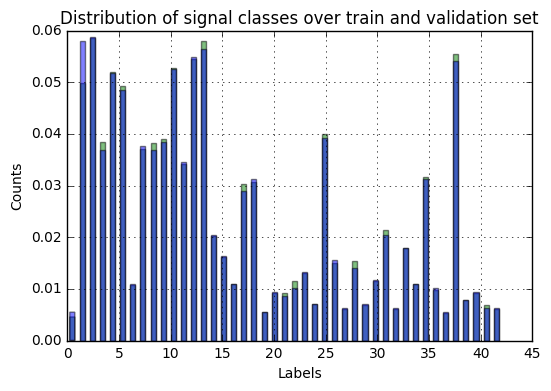

In [12]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import numpy as np

# Visualizations will be shown in the notebook.
%matplotlib inline

train_unique, train_counts = np.unique(y_train, return_counts=True)
validation_unique, valition_counts = np.unique(y_validation, return_counts=True)

fig = plt.figure()
n, bins, patches = plt.hist(y_train, bins=train_unique.shape[0], facecolor='green', alpha=0.5, rwidth=0.5, normed=True)
n, bins, patches = plt.hist(y_validation, bins=validation_unique.shape[0], facecolor='blue', alpha=0.5, rwidth=0.5, normed=True)

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title(r'Distribution of signal classes over train and validation set')
plt.grid(True)

plt.show()

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

First, I added more data by randomly rotating(-15, 15), translating(-2.0, 2.0) and scaling(0.9, 1.1) the original training data (based on LeCun's papaer) because convolutional networks have invariant to small scale, translation and rotation.

After that, I extract 20% data set from each category and put them together as the validation set. 

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 10
BATCH_SIZE = 128

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    layer_depth = {
        'layer_1': 6,
        'layer_2': 16,
        'layer_3': 120,
        'layer_4': 84,
        'layer_5': 43
    }
    
    weights = {
        'layer_1': tf.Variable(tf.truncated_normal(
            [5, 5, 1, layer_depth['layer_1']], mu, sigma)),
        'layer_2': tf.Variable(tf.truncated_normal(
            [5, 5, layer_depth['layer_1'], layer_depth['layer_2']], mu, sigma)),
        #'layer_3': tf.Variable(tf.truncated_normal(
        #    [14*14*layer_depth['layer_1'] + 5*5*layer_depth['layer_2'], layer_depth['layer_3']], mu, sigma)),
        'layer_3': tf.Variable(tf.truncated_normal(
            [5*5*layer_depth['layer_2'], layer_depth['layer_3']], mu, sigma)),
        'layer_4': tf.Variable(tf.truncated_normal(
            [layer_depth['layer_3'], layer_depth['layer_4']], mu, sigma)),
        'layer_5': tf.Variable(tf.truncated_normal(
            [layer_depth['layer_4'], layer_depth['layer_5']], mu, sigma))
    }
    biases = {
        'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
        'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
        'layer_3': tf.Variable(tf.zeros(layer_depth['layer_3'])),
        'layer_4': tf.Variable(tf.zeros(layer_depth['layer_4'])),
        'layer_5': tf.Variable(tf.zeros(layer_depth['layer_5']))
    }
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)
    # Flatten. Input = 14x14x6. Output = 1176.
    fc0 = tf.contrib.layers.flatten(conv1)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
    # Flatten. Input = 5x5x16. Output = 400.
    fc1 = tf.contrib.layers.flatten(conv2)
    
    # Concatenate layer 1 and layer 2
    #fc1 = tf.concat(1, [fc0, fc1])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(
        tf.matmul(fc1, weights['layer_3']),
        biases['layer_3'])
    # Activation.
    fc1 = tf.nn.tanh(fc1)
    # Drop out
    #fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(
        tf.matmul(fc1, weights['layer_4']),
        biases['layer_4'])
    # Activation.
    fc2 = tf.nn.tanh(fc2)
    #fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['layer_5']), biases['layer_5'])
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The architecture is almost the same as Lenet.
<p>1. Layer 1:</p>
    <p>Convolution layer: 32x32x1 -> 28x28x6</p>
    <p>Pooling layer: 28x28x6 -> 14x14x6</p>
    <p>Flatten output in 2: 14x14x6 -> 1176</p>
<p>2. Layer 2:</p>
    <p>Convolution layer: 14x14x6 -> 10x10x16</p>
    <p>Pooling layer: 10x10x16 -> 5x5x16</p>
    <p>Flatten output in 5: 5x5x6 -> 400</p>
    <p>Combine output in 3 and 6 -> 1176 + 400 -> 1576 (MS architecture)</p>
<p>3. Layer 3:</p>
    <p>Fully connected layer: 1576 -> 120</p>
<p>4. Layer 4:</p>
    <p>Fully connected layer: 120 -> 84</p>
<p>5. Layer 5:</p>
    <p>output layer: 84 -> 43</p>

In [14]:
### Train your model here.

### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0 
    sess = tf.get_default_session()
    X_data, y_data = shuffle(X_data, y_data)
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [15]:
#start train
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess: 
    with tf.device("/gpu:0"):
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})

            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.949

EPOCH 2 ...
Validation Accuracy = 0.976

EPOCH 3 ...
Validation Accuracy = 0.986

EPOCH 4 ...
Validation Accuracy = 0.991

EPOCH 5 ...
Validation Accuracy = 0.994

EPOCH 6 ...
Validation Accuracy = 0.992

EPOCH 7 ...
Validation Accuracy = 0.997

EPOCH 8 ...
Validation Accuracy = 0.994

EPOCH 9 ...
Validation Accuracy = 0.998

EPOCH 10 ...
Validation Accuracy = 0.997

Model saved


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**
1. Used origianl setting of LeNet.
2. Optimizer: AdamOptimizer
3. Batch size: 128
4. Epochs: 10
5. Convolution filter size: 5x5 for both convolutional layers
6. weights initialization mu = 0 sigma = 0.1
7. filter stride = 1

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
First of all, I feel really suprised that image data preprocessing provides the most significant result improvements during the whole project.
Here is how I come up with the final solution.
1. Tested with bare lenet without any data preprocessing and keep all the hyper parameters the same as the setting in video. Achieved aroudn 91% validation and 87% test accuracy.
2. Converted image data to YUV, used sklearn.preprocessing.scale to standadize three channels (only global nomalization) and generated three times additional data with small rotations, translations, and scale. Passed through the same LeNet architecture. Achieved around 98% validation and 93% test accuracy.
3. Then I took out the U, V channel to use only Y channel by itself. passed throught the sane Lenet architecture. Also achieved 98% validation and 93% test accuracy.
4. Then I felt data preprocessing cannot give me any improvements on the performance. The accuracy should be further improved by changing the network architecture. So I started to tune the model. I tried to mimic LeCun's solution in paper to have 22 and 38 depth for the two convolution layers. The result does not improve. Then I tried to use 108 and 108 depth with dropout keep_prob 0.8 as suggested in the paper for both layers. the result downgraded a lot. It seems like overfitting. The I switched the convolutional layer depth to 6 and 16 again but use drop-out keep_prob 0.5 either after convolutional layer or fully connected layer. The performance either downgraded or kept the same. I also tried to combine the output of first the second convolutional layers, flattened them and fed into the next fully connected layer (MS architecture in LeCun's paper). Performance still kept the same.
5. Then I went back to data preprocessing. Instead of sklearn.preprocessing.scale using this time I used opencv gaussian blur to perform local nomalization on only Y channel of the image. After tested on different gaussian window size 5x5, 7x7, 9x9x, 11x11, 13x13, 15x15, I foudn out 13x13 yields the best performance. It is very surprising to see the result improved much more than tuning the network architecture. Using 13x13 gaussian window size yields around 99.6% validation and 96.2 test accuracy.5. Then I went back to data preprocessing. Instead of using , this time I used opencv gaussian blur to perform local nomalization on only Y channel of the image. After tested on different gaussian window size 5x5, 7x7, 9x9x, 11x11, 13x13, 15x15, I found out 13x13 yields the best performance. It is very surprising to see the result improved much more than tuning the network architecture. Using 13x13 gaussian window size yields around 99.4% validation and 96.2 test accuracy.
6. In Lecun's paper, it also gives an idea of eaqually chosing validation images from each sign category. By doing that, I increase the validation accuracy to 99.8%. But test accuracy keeps the same.
6. It seems LeNet is very stable. Although it claims it is best for handwritten/machine-printed character recognition, with enough pre-processing, it can also achieve a relatively good goal. It may because it is robost to distortions and simple geometric transformations.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import cv2
import numpy as np

image_path = "images/"
images = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg']

# Concatenate testing images into new testing set
preprocessed_images = []
for image in images:
    img = cv2.imread(image_path + image, 1)
    # Preprocessing new testing data
    preprocessed_image = imagePreprocessing(img)
    preprocessed_images.append(preprocessed_image)

new_X_test = np.concatenate([img[np.newaxis] for img in preprocessed_images])
new_y_test = np.array([25, 14, 1, 31, 17, 22, 13, 15, 4, 26])


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_test_accuracy = evaluate(new_X_test, new_y_test)
    print("New Test Accuracy = {:.3f}".format(new_test_accuracy))

New Test Accuracy = 0.900


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



(12630, 32, 32, 3)


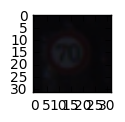

In [21]:
from os import listdir
from os.path import isfile, join
import cv2
print(X_test_original.shape)
indices = [6469]
for index in indices:
    plt.figure(figsize=(1,1))
    plt.imshow(X_test_original[index])

**Answer:**
The above 10 images are the ones I downloaded from the internet. Acutally I specifically searched for German traffic signs because I know it may fail if I use other countries' traffic signal. As you can see above I achieve 90% test accuracy for the all ten image. The one I failed the most is image No. 9 speed limit 70. As I checked in the training dataset(showed above), this set of training images are taken under extreme low light condition. It is very hard for the claasifier to find enough details in the image. But the overall performance is acceptable.

In [22]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.953


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


# **Answer:**
The model gave 90% accuracy on 10 downloaded images, while gave 95.3% on testing dataset. The accuracy on downloaded images is 5.3% lower than the accuracy on the test set. There could be several possible causes:
1. The number of downloaded images is too small to give an accuracy that can well present the model accuracy.
2. The model is overfitting. It works better on one test set than the other. Adding dropout could help with the performance on the downloaded images.

(5, 32, 32, 1)
index:  [ 983   38 2058 3147 7927]
predicted:  TopKV2(values=array([[ 19.19945908,   8.5399313 ,   8.4332056 ,   7.83804846,
          6.59929085],
       [ 21.44423103,   8.68918324,   8.09891129,   5.94658041,
          5.55486393],
       [ 26.14790344,  10.23496437,   6.61226606,   4.69734097,
          4.10144186],
       [ 15.50020027,  14.22484493,  11.03243637,   6.04794073,
          5.88977098],
       [ 10.51589394,   6.4775815 ,   6.13548613,   5.98757696,
          5.30067348]], dtype=float32), indices=array([[ 5,  3,  6,  1,  2],
       [16,  0,  9, 39,  8],
       [12, 40,  7, 35, 42],
       [ 1,  2,  4,  7,  5],
       [35,  3,  5, 34,  8]], dtype=int32))
truth:  [ 5 16 12  1 35]


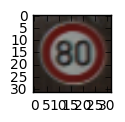

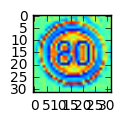

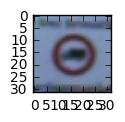

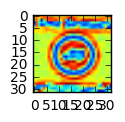

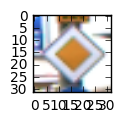

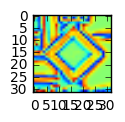

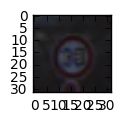

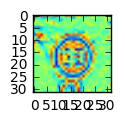

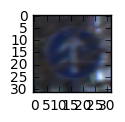

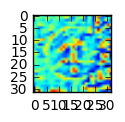

In [23]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
def getSoftmax(X_data):
    num_examples = len(X_data)
    total_accuracy = 0 
    sess = tf.get_default_session()
    k = 5
    top_k = tf.nn.top_k(logits, k)
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        softmax = sess.run(top_k, feed_dict={x: batch_x, keep_prob: 1})
    return softmax

#index = np.asarray([random.randint(0, len(X_test))])

index=np.asarray([983, 38, 2058, 3147, 7927])
single_image = [X_test[index]]
single_X = np.concatenate([img[np.newaxis] for img in X_test[index]])
print (single_X.shape)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("index: ", index)
    print("predicted: ", getSoftmax(single_X))
    print("truth: ", y_test[index])

for i in range(index.shape[0]): 
    plt.figure(figsize=(1,1))
    plt.imshow(X_test_original[index[i], :, :, :])
    plt.figure(figsize=(1,1))
    plt.imshow(X_test[index[i], :, :, 0])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
I picked five images from the test set. The first three images are correctly classified while the later two are not. When looking at the original image and preprocessed image shown above, the first three are really easy to tell which sign they are. As suggested by the softmax activation, they are almost twice/triple the second activation(very certain). But for the last two, correct sign produces second activation and they are only a little bit lower than the first activation (wrong). When we look at the iamge, it is even hard for human eye to recognize because these two images are dark and blurry.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.